In [1]:
import pickle
import json
import torch
from glob import glob

# data loading

## BERT embedding loading

In [2]:
pt_files = sorted(glob('../bert_file/*.pt'))
pt_files_index = [int(pt.split('_')[-1].split('.')[0]) for pt in pt_files]

In [3]:
len(pt_files)

17743

In [4]:
for pt in pt_files:
    try:
        torch.load(pt)
    except:
        print(pt)

../bert_file/doc_11926.pt
../bert_file/doc_17742.pt


In [5]:
tensors = [torch.load(pt) for pt in pt_files
          if pt not in ['../bert_file/doc_11926.pt', '../bert_file/doc_17742.pt']]

## Label loading 

In [6]:
with open('../file/train.jsonl') as f:
    data = [json.loads(line) for line in f]

In [7]:
data_sample = [data[index] for index in pt_files_index]

In [8]:
# data_sample

In [9]:
label_sample = [torch.Tensor([1 if _ in data['extractive'] else 0 
                            for _ in range(len(data['article_original']))]) 
                for idx, data in enumerate(data_sample)
               if idx not in [11926, 17742]]

In [10]:
for idx, x in enumerate(list(zip([tensor.shape[0] for tensor in tensors], [label.shape[0] for label in label_sample]))):
    if x[0]!=x[1]:
        print(idx)
        print(x)

## Dataset 

In [11]:
from torch.utils.data import Dataset, DataLoader

In [12]:
class transformerDataset(Dataset):
    def __init__(self, data_x, data_y, transform_x=None, transform_y=None):
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        return len(self.data_x)
    
    def __getitem__(self, idx):
        sample_x = self.data_x[idx]
        sample_y = self.data_y[idx]
        return sample_x, sample_y

In [103]:
def collate_fn_padd(batch):
    '''
    Padds batch of variable length

    note: it converts things ToTensor manually here since the ToTensor transform
    assume it takes in images rather than arbitrary tensors.
    '''
    ## padd
    batch = [torch.Tensor(t[0]).to(device) for t in batch]
    batch_y = [torch.Tensor(t[1]).to(device) for t in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch)
#     print(batch_y)
    return batch, batch_y

In [104]:
# tensors = collate_fn_padd(tensors)

In [105]:
# tensors.shape

In [106]:
# label_sample

In [107]:
ds = transformerDataset(tensors, label_sample)
dl = DataLoader(ds, batch_size=4, collate_fn=collate_fn_padd)

In [108]:
for d in ds:
    print(d[1])
    break

tensor([1., 1., 1., 0., 0., 0., 0., 0., 0.])


In [109]:
for d in dl:
#     print(d[0].shape)
    print(d[1])
    break

NameError: name 'device' is not defined

## model 

In [65]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [26]:
# data_sample

In [46]:
# BERT_EMBEDDING_DIM = 768

In [48]:
# encoder_layer = TransformerEncoderLayer(d_model=BERT_EMBEDDING_DIM, nhead=2, dim_feedforward=128, dropout=0.5)
# transformer_encoder = TransformerEncoder(encoder_layer, num_layers=1)

In [49]:
# tensors[0].shape

In [50]:
# linear = nn.Linear(in_features=768, out_features=1)

In [31]:
tensors[1].shape

torch.Size([21, 768])

In [32]:
tensors[0].unsqueeze(0).shape

torch.Size([1, 9, 768])

In [33]:
trans_output = transformer_encoder(tensors[0].unsqueeze(0))

In [34]:
trans_output.shape

torch.Size([1, 9, 768])

In [35]:
output = linear(trans_output)
sigmoid = nn.Sigmoid()
output = sigmoid(output)
output.shape

torch.Size([1, 9, 1])

In [36]:
target = torch.Tensor(label_sample[0])

In [37]:
output.shape

torch.Size([1, 9, 1])

In [38]:
criterion = nn.BCELoss()

In [39]:
output.shape, target.shape

(torch.Size([1, 9, 1]), torch.Size([9]))

In [40]:
criterion(output, target.view(1,-1,1))

tensor(0.7749, grad_fn=<BinaryCrossEntropyBackward>)

In [41]:
class PositionalEncoding(nn.Module):
    # positional encoding layer 따로 정의 
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model) # positonal encoding
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) # 짝수는 sin 함수 적용
        pe[:, 1::2] = torch.cos(position * div_term) # 홀수는 cos 함수 적용
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [42]:
class TransformerModel(nn.Module):

    def __init__(self, ninp, nhead, nhid, n_class, dropout=0.5):
        # ntoken : number of sentence
        # ninp : the number of expected features in the input
        # nhead : the number of heads in multi-head attention model 
        # nhid : the dimension of the feedforward network model 
        # nlayers : the number of class
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, n_class)
        self.ninp = ninp
        self.linear = nn.Linear(in_features=ninp, out_features=n_class)
        self.sigmoid = nn.Sigmoid()
    
    def init_weights(self):
        initrange = 0.1
        # encoder의 nn.Embedding의 레이어 초기화
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = src * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.linear(output)
        output = self.sigmoid(output)
        return output

In [43]:
model = TransformerModel(ninp=768, nhead=4, nhid=128, n_class=1)
lr = 0.0005
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [112]:
loss_list = []
for epoch in range(10):
    i = 0 
    for tensor, label in zip(tensors, label_sample):
        tensor = tensor.unsqueeze(0)
        label = label.view(1, -1, 1)
        output = model(tensor)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        i += 1
        if i % 1000 == 0 :
            loss_list.append(loss)

In [121]:
!pip install matplotlib

     |████████████████████████████████| 11.6 MB 12.0 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 12.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 10.7 MB/s eta 0:00:01


In [122]:
import matplotlib.pyplot as plt

In [125]:
# loss_list

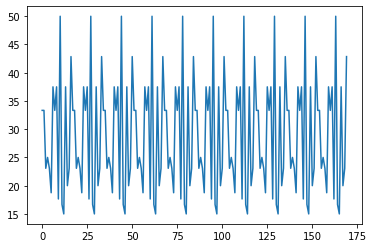

In [123]:
plt.plot(loss_list)

In [ ]:
criterion = nn.CrossEntropyLoss()
lr = 5.0 # 학습률
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

In [101]:

tensors[0]

tensor([[ 0.0462,  0.0118,  0.5724,  ...,  0.1374, -0.1229, -0.0062],
        [ 0.0160,  0.0131,  0.1649,  ...,  0.0511, -0.0885, -0.0204],
        [ 0.0786, -0.1505, -0.2084,  ...,  0.0413, -0.0241, -0.0316],
        ...,
        [ 0.0012, -0.0080,  0.3905,  ...,  0.0318, -0.0842, -0.1099],
        [-0.0177, -0.0156, -0.3838,  ..., -0.0009, -0.0127, -0.0464],
        [-0.0084, -0.0161,  0.0965,  ...,  0.0449, -0.0278, -0.0740]],
       requires_grad=True)